In [25]:
import numpy as np
import h5py,time, matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, minimize
from drift.core import manager
import corrcal2
import sys
sys.path.insert(0,'/home/zahra/PIPELINE')
from log_red_cal_new import Visibilities_grid, Bls_counts, colour_scatterplot, Scatterplot
from decimal import Decimal
from operator import add,sub
from scipy.optimize import LinearConstraint, BFGS, Bounds
import scipy as sp


In [42]:
ts_2=h5py.File('/home/zahra/PIPELINE/example_3by3_hiraxtrans_lmax_mmax_200/draco_synthesis_nofluc/maps/tstream_2.h5','r')
ag_2=h5py.File('/home/zahra/PIPELINE/example_3by3_hiraxtrans_lmax_mmax_200/draco_synthesis_nofluc/rand_gains/sig_no_fluc/app_gain_2.h5','r')
rg_2=h5py.File('/home/zahra/PIPELINE/example_3by3_hiraxtrans_lmax_mmax_200/draco_synthesis_nofluc/rand_gains/sig_no_fluc2.h5','r')

gn_2=h5py.File('/home/zahra/PIPELINE/example_3by3_hiraxtrans_lmax_mmax_200/draco_synthesis_nofluc/rand_gains/ts_final/app_gain_noise_2.h5','r')

ts_var=h5py.File('/home/zahra/PIPELINE/ex_3by3_dish_var/draco_synthesis_nofluc/maps/tstream_2.h5','r')
ag_var=h5py.File('/home/zahra/PIPELINE/ex_3by3_dish_var/draco_synthesis_nofluc/rand_gains/sig_no_fluc/app_gain_2.h5','r')
rg_var=h5py.File('/home/zahra/PIPELINE/ex_3by3_dish_var/draco_synthesis_nofluc/rand_gains/sig_no_fluc2.h5','r')

gn_var=h5py.File('/home/zahra/PIPELINE/ex_3by3_dish_var/draco_synthesis_nofluc/rand_gains/ts_final/app_gain_noise_2.h5','r')


In [44]:
xx,yy=np.meshgrid(x,y)
umat=xx-xx.T
vmat=yy-yy.T


isok=np.where(ant1<ant2)
u_org=umat[isok]
v_org=vmat[isok]

print u_org, v_org


IndexError: index 18 is out of bounds for axis 0 with size 18

In [49]:
m = manager.ProductManager.from_config('/home/zahra/PIPELINE/example_3by3_hiraxtrans_lmax_mmax_200/prod_params_custom.yaml')

#m=manager.ProductManager.from_config('/home/zahra/PIPELINE/ex_3by3_dish_var/prod_params_custom.yaml')
#Scatterplot(m)

t=m.telescope
x=t.feedpositions[:,0] #these are x and y positions not x and y polarizations
y=t.feedpositions[:,1]


#klobj=m.kltransforms['kl']

time_channel=400
Ndish=9
correlation_arr,sum_counts,corr_counts=Bls_counts(m)

Nbls,_=correlation_arr.shape

v1=np.zeros(2*Nbls)
v1[0::2]=1
v2=np.zeros(2*Nbls)
v2[1::2]=1
vecs=1.e3*np.vstack([v1,v2])


lims=sum_counts
#lims=np.append(lims,lims)
#diag=sigma**2*np.ones(72)/1000


src=np.zeros(2*Nbls)
#src=1000*v1

ant1=correlation_arr[:,0].astype(int)
ant2=correlation_arr[:,1].astype(int)

print ant1.shape, ant2
print lims

Product directory: /home/zahra/PIPELINE/example_3by3_hiraxtrans_lmax_mmax_200/bt_matrices
(36,) [3 4 5 6 7 8 1 2 4 5 7 8 4 5 7 8 3 4 6 7 6 7 8 2 5 8 7 8 6 7 5 8 3 6 8 6]
[ 6 12 16 20 23 26 28 30 32 34 35 36]


In [28]:
runs=1
random_pt1=np.load('random_pt1.npy')

def fit_gains(m,file_no_gain,gain, file_with_gain,file_gain_noise, time_channel,Tsys,ndays,random):
    gg=np.zeros((runs,Ndish*2))
    for run in range(runs):
        arr=Visibilities_grid(m,file_no_gain,gain,file_with_gain,file_gain_noise,time_channel,Tsys,ndays)
        vis=arr[2][:,time_channel]
        sigma=arr[-1]
        diag=sigma**2*np.ones(2*Nbls)
        print (sigma)
        mat=corrcal2.sparse_2level(diag,vecs,src,2*lims) #init
        
        gain=gain['gain'][0,:Ndish,time_channel]
        sim_gains=np.append(gain.real,gain.imag)
        sim_gains=np.zeros(Ndish*2)
        sim_gains[0::2]=gain.real
        sim_gains[1::2]=gain.imag
        sim_gains_amp=sim_gains[0::2]
        sim_gains_phase=sim_gains[1::2]
         
        mult=random+1.

        gvec=np.array([])
        for i in range(len(sim_gains)):
            gvec=np.append(gvec,sim_gains[i]+random[i])
            #gvec=np.append(gvec,sim_gains[i]*mult[i])


        data=np.zeros(2*vis.size)
        data[0::2]=vis.real
        data[1::2]=vis.imag
        fac=1.;
        normfac=1.
        asdf=fmin_cg(corrcal2.get_chisq,gvec*fac,corrcal2.get_gradient,(data,mat,ant1,ant2,fac,normfac))
        #asdf=fmin_cg(corrcal2.get_chisq_dense,gvec*fac,corrcal2.get_gradient_dense,(data,diag_mat,vecs_mat,ant1,ant2,fac,normfac))
        fit_gains_run=asdf/fac
        gg[run,:]=fit_gains_run
        
        gain_std=(np.std(gg,axis=0)/np.sqrt(runs)).flatten()
        gain_mean=np.mean(gg,axis=0).flatten() #shape is 98, we take every second one for amp so shape is 49
        rec_gains_amp=gain_mean[0::2]
        rec_gains_phase=gain_mean[1::2]
        gain_std_amp=gain_std[0::2]
        gain_std_phase=gain_std[1::2]

    return rec_gains_amp, sim_gains_amp
    
    
rec_gains_amp_2, sim_gains_amp_2=fit_gains(m,ts_2,rg_2,ag_2, gn_2,time_channel,50,1,random_pt1)

rec_gains_amp_var, sim_gains_amp_var=fit_gains(m,ts_var,rg_var,ag_var, gn_var,time_channel,50,1,random_pt1)


(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 527.638325
         Iterations: 1
         Function evaluations: 69
         Gradient evaluations: 55
(0.012207031977595827, 'sigma_gn')
0.012207031977595827
         Current function value: 98.139354
         Iterations: 1
         Function evaluations: 90
         Gradient evaluations: 76


In [29]:
def rel_err(rec_gains_amp,sim_gains_amp):
    rel_err_amp=np.abs(rec_gains_amp-sim_gains_amp)/sim_gains_amp

    rel_err_amp_mean=np.mean(rel_err_amp)
    rel_err_amp_std=np.std(rel_err_amp,ddof=1)
    return rec_gains_amp, rel_err_amp, rel_err_amp_mean, rel_err_amp_std

rel_err_2=rel_err(rec_gains_amp_2,sim_gains_amp_2)

rel_err_var=rel_err(rec_gains_amp_var,sim_gains_amp_var)


In [30]:
rec_gains_amp_var, sim_gains_amp_var

(array([1.07606134, 0.93874357, 0.89563575, 1.24816228, 0.87842268,
        0.93795804, 0.88412302, 0.94902637, 1.11615181]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1.]))

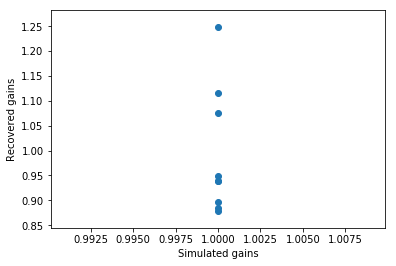

In [31]:
fig, ax = plt.subplots()

lims = [0.5,  # min of both axes
    np.max([ax.get_xlim()]),  # max of both axes
]
ax.scatter(sim_gains_amp_var, rec_gains_amp_var)
#ax.plot(lims, lims,'g')
#plt.errorbar(x_true_real[:Ndish,time_channel],x_rec_real[:Ndish,time_channel],xerr=None,yerr=error[:Ndish],linestyle="None")
plt.xlabel('Simulated gains')
plt.ylabel('Recovered gains')
lim=.002
#plt.ylim(0.9,1.025)
#plt.xlim(0.9,1.1)

In [ ]:
runs=1
random_pt1=np.load('random_pt1.npy')

def fit_gains_gridded(m,file_no_gain,gain, file_with_gain,file_gain_noise, time_channel,Tsys,ndays,random):
    gg=np.zeros((runs,Ndish*2))
    for run in range(runs):
        arr=Visibilities_grid(m,file_no_gain,gain,file_with_gain,file_gain_noise,time_channel,Tsys,ndays)
        vis=arr[2][:,time_channel]
        sigma=arr[-1]
        diag=sigma**2*np.ones(2*Nbls)
        print (sigma)
        mat=corrcal2.sparse_2level(diag,vecs,src,2*lims) #init
        
        gain=gain['gain'][0,:Ndish,time_channel]
        sim_gains=np.append(gain.real,gain.imag)
        sim_gains=np.zeros(Ndish*2)
        sim_gains[0::2]=gain.real
        sim_gains[1::2]=gain.imag
        sim_gains_amp=sim_gains[0::2]
        sim_gains_phase=sim_gains[1::2]
         
        mult=random+1.

        gvec=np.array([])
        for i in range(len(sim_gains)):
            gvec=np.append(gvec,sim_gains[i]+random[i])
            #gvec=np.append(gvec,sim_gains[i]*mult[i])


        data=np.zeros(2*vis.size)
        data[0::2]=vis.real
        data[1::2]=vis.imag
        fac=1.;
        normfac=1.
        asdf=fmin_cg(corrcal2.get_chisq,gvec*fac,corrcal2.get_gradient,(data,mat,ant1,ant2,fac,normfac))
        #asdf=fmin_cg(corrcal2.get_chisq_dense,gvec*fac,corrcal2.get_gradient_dense,(data,diag_mat,vecs_mat,ant1,ant2,fac,normfac))
        fit_gains_run=asdf/fac
        gg[run,:]=fit_gains_run
        
        gain_std=(np.std(gg,axis=0)/np.sqrt(runs)).flatten()
        gain_mean=np.mean(gg,axis=0).flatten() #shape is 98, we take every second one for amp so shape is 49
        rec_gains_amp=gain_mean[0::2]
        rec_gains_phase=gain_mean[1::2]
        gain_std_amp=gain_std[0::2]
        gain_std_phase=gain_std[1::2]

    return rec_gains_amp, sim_gains_amp
    
    
rec_gains_amp_2, sim_gains_amp_2=fit_gains(m,ts_2,rg_2,ag_2, gn_2,time_channel,50,1,random_pt1)

rec_gains_amp_var, sim_gains_amp_var=fit_gains(m,ts_var,rg_var,ag_var, gn_var,time_channel,50,1,random_pt1)


(0.9, 1.1)

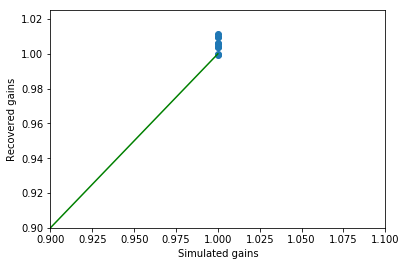

In [23]:
fig, ax = plt.subplots()

lims = [0.5,  # min of both axes
    np.max([ax.get_xlim()]),  # max of both axes
]
ax.scatter(sim_gains_amp_2, rec_gains_amp_2)
ax.plot(lims, lims,'g')
#plt.errorbar(x_true_real[:Ndish,time_channel],x_rec_real[:Ndish,time_channel],xerr=None,yerr=error[:Ndish],linestyle="None")
plt.xlabel('Simulated gains')
plt.ylabel('Recovered gains')
lim=.002
plt.ylim(0.9,1.025)
plt.xlim(0.9,1.1)